# Minimal notebook with fetching wind data from HSDS + spatial & vertical interpolation + ANL's obstactle model

### Important HSDS info:
- accessing wind data stored in AWS using HSDS **works only from NREL networks**
- to enable HSDS connectons, you should have a file `~/.hscfg` with the following contents:
```
hs_endpoint = <endpoint>
hs_username = <user>
hs_password = <password>
hs_api_key = <key>
hs_bucket = nrel-pds-hsds
```
- collaborators from outside of NREL should use another notebook with no HSDS operations (i.e. reading pre-saved wind data)

In [37]:
import numpy as np
import pandas as pd
import time
import h5pyd
import geopandas as gpd
from dw_tap.data_fetching import getData
from dw_tap.power_output import estimate_power_output
from dw_tap.lom import run_lom

z_turbine = 50 # turbine height in [m]
lat, lon = 42.510051, -92.45786
obstacle_file = "../sites/new_site.geojson"

t_start = time.time()

# Open the wind data "file"
# server endpoint, username, password are found in ~/.hscfg
f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

t_fetch_start = time.time()
# The last three arguments limit data fetching to every 12 hours for 1 year
atmospheric_df = getData(f, lat, lon, z_turbine, "IDW", 
                         power_estimate=True,
                         inverse_monin_obukhov_length=True,
                         start_time_idx=0, end_time_idx=4380, time_stride=1)

#If you want to save to CSV file for ANL use
#df.to_csv('../data/180_1year_12hourgranularity.csv')

t_fetch = time.time() - t_fetch_start
print('Data fetching time: %.2f (s)' % t_fetch)

obstacles_df = gpd.read_file(obstacle_file)
x1_turbine, y1_turbine = lat, lon
xy_turbine = [np.array([x1_turbine, y1_turbine])]

t_lom_start = time.time()
predictions_df = \
    run_lom(atmospheric_df, obstacles_df, xy_turbine, z_turbine)

t_lom = time.time() - t_lom_start
print('Running LOM: %.2f (s)' % t_lom)

t_power_start = time.time()
kw, above_curve, below_curve, above_curve_list, below_curve_list = \
    estimate_power_output(predictions_df, atmospheric_df["temp"], atmospheric_df["pres"])  
t_power = time.time() - t_power_start
print('Power estimation: %.2f (s)' % t_power)

t_total = time.time()-t_start
print('Total time: %.2f (s)' % t_total)

Data fetching time: 14.50 (s)
run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.48  min
Running LOM: 88.85 (s)
Power estimation: 0.17 (s)
Total time: 104.12 (s)


In [38]:
atmospheric_df

,datetime,ws,wd,temp,pres,inversemoninobukhovlength_2m
0,2007-01-01 00:00:00,10.361467,314.437509,274.469742,96441.446165,-0.001612
1,2007-01-01 01:00:00,10.049069,316.215910,273.477890,96508.945734,-0.002222
2,2007-01-01 02:00:00,9.910439,312.451156,272.585220,96581.626677,-0.002441
3,2007-01-01 03:00:00,10.175206,312.137807,272.341064,96653.508749,-0.001831
4,2007-01-01 04:00:00,10.395692,312.445915,272.054199,96703.903491,-0.001612
...,...,...,...,...,...,...
4376,2007-07-02 08:00:00,7.404545,136.035031,289.187286,98479.588049,0.053047
4377,2007-07-02 09:00:00,6.830597,136.037439,288.361755,98498.260771,0.091702
4378,2007-07-02 10:00:00,6.771773,134.570219,287.537766,98511.153621,0.078317
4379,2007-07-02 11:00:00,6.892769,136.178170,287.023529,98523.297660,0.058239


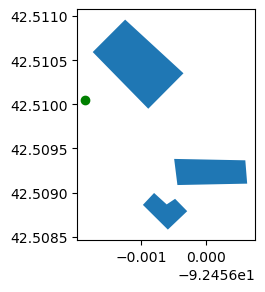

In [39]:
ax = obstacles_df.plot(figsize=(3,3));
ax.scatter(lon, lat, color="green");

In [40]:
atmospheric_df

,datetime,ws,wd,temp,pres,inversemoninobukhovlength_2m
0,2007-01-01 00:00:00,10.361467,314.437509,274.469742,96441.446165,-0.001612
1,2007-01-01 01:00:00,10.049069,316.215910,273.477890,96508.945734,-0.002222
2,2007-01-01 02:00:00,9.910439,312.451156,272.585220,96581.626677,-0.002441
3,2007-01-01 03:00:00,10.175206,312.137807,272.341064,96653.508749,-0.001831
4,2007-01-01 04:00:00,10.395692,312.445915,272.054199,96703.903491,-0.001612
...,...,...,...,...,...,...
4376,2007-07-02 08:00:00,7.404545,136.035031,289.187286,98479.588049,0.053047
4377,2007-07-02 09:00:00,6.830597,136.037439,288.361755,98498.260771,0.091702
4378,2007-07-02 10:00:00,6.771773,134.570219,287.537766,98511.153621,0.078317
4379,2007-07-02 11:00:00,6.892769,136.178170,287.023529,98523.297660,0.058239


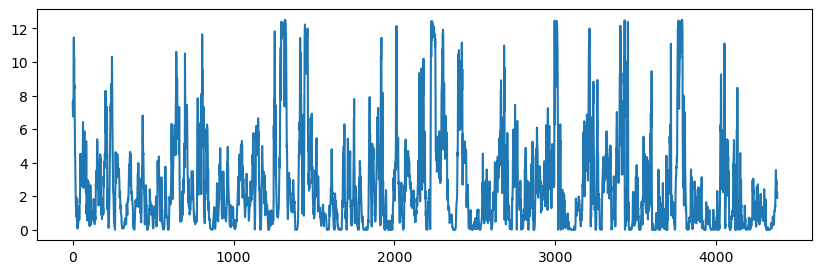

In [41]:
pd.Series(kw).plot(figsize=(10,3));

In [42]:
atmospheric_df["ws"].mean()

6.2666446275307255

In [43]:
kw.mean()

2.567495146671043

In [44]:
kw.sum()

11248.196237565848

In [8]:
# pd.DataFrame({"lat": [lat], "lon": [lon], "hub_height_m": z_turbine}).T[0].to_json("../output/site_specs_180.json")